In [1]:
from pyhdf.SD import SD, SDC
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

Matplotlib created a temporary config/cache directory at /var/folders/5b/69fnmcl56xv87h47bb4l_v8w0000gn/T/matplotlib-gck_q982 because the default path (/Users/personal/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
filename = "MODIS_Jan2021.hdf"
file = SD(filename, SDC.READ)

In [3]:
datasets_dic = file.datasets()
for idx,sds in enumerate(datasets_dic.keys()):
    print (idx,sds)

0 LST_Day_CMG
1 QC_Day
2 Day_view_time
3 Day_view_angl
4 Clear_sky_days
5 LST_Night_CMG
6 QC_Night
7 Night_view_time
8 Night_view_angl
9 Clear_sky_nights
10 Emis_20
11 Emis_22
12 Emis_23
13 Emis_29
14 Emis_31
15 Emis_32
16 Percent_land_in_grid


(3600, 7200)


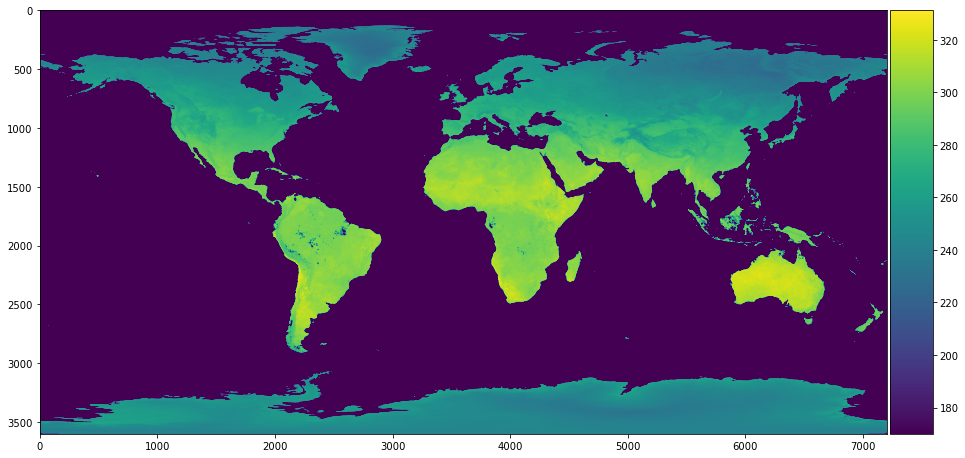

In [4]:
sds_obj = file.select('LST_Day_CMG') # select dataset  
data = sds_obj.get()/50. #Scale to Kelvins
print(data.shape)
antarctica = data[2900:,:] # zoom on Antarctica
fig, ax = plt.subplots(figsize=(16,9))
im = plt.imshow(data, vmin=170)
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

In [5]:
#present the grid coordinates
modis_map_scale = 0.05#deg
theta_modis, phi_modis = np.meshgrid(np.radians(np.arange(0, 180, modis_map_scale)), 
                         np.radians(np.arange(0, 360, modis_map_scale)))

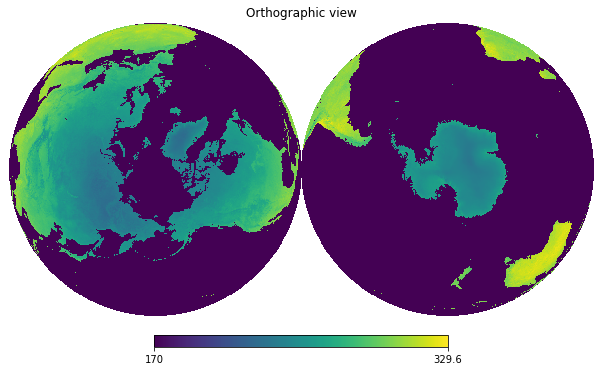

In [6]:
#Go to healpix arrays
counts = np.zeros(hp.nside2npix(512))
counts[hp.ang2pix(512, theta_modis, phi_modis)]+=1
temperature = np.ones_like(counts)*hp.UNSEEN
temperature[hp.ang2pix(512, theta_modis, phi_modis)]=np.swapaxes(data, 1,0)
hp.orthview(temperature, xsize=1200, min=170, flip="geo", rot=[0,90,0])

4.2457679265248585


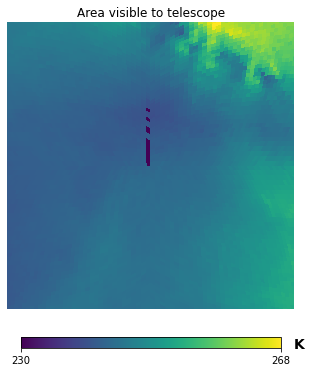

In [7]:
tele_h_asl = 2e4#20km altitude
anta_h_asl = 2.5e3#2500m plateau
tele_h_abg = tele_h_asl - anta_h_asl
r_pole = 6356752.3 #Polar radius, smaller than average or equatorial radius
r_anta = r_pole + anta_h_asl
theta_fov = np.arccos((r_anta)/(r_anta+tele_h_abg))#The section of the ground visible from the telescope
print(np.degrees(theta_fov))
hp.cartview(temperature, xsize=1200, min=230, flip="geo", rot=[0,-90,0], 
            latra=[-np.degrees(theta_fov), np.degrees(theta_fov)], 
            lonra=[-np.degrees(theta_fov), np.degrees(theta_fov)],
           unit="K", title="Area visible to telescope")

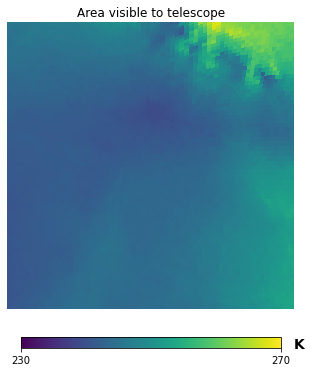

In [8]:
#we have some pixels to fix
theta, phi = hp.pix2ang(512, np.arange(hp.nside2npix(512)))
zero_temp_pix = np.intersect1d(np.argwhere(temperature==0), np.argwhere(theta>=np.pi-theta_fov))

for i, pix in enumerate(zero_temp_pix):
    neighbors = hp.get_all_neighbours(512, pix)
    neighbors = neighbors[temperature[neighbors]!=0]
    temperature[pix] = np.average(temperature[neighbors])
hp.cartview(temperature, xsize=1200, min=230, max=270, flip="geo", rot=[0,-90,0], 
            latra=[-np.degrees(theta_fov), np.degrees(theta_fov)], 
            lonra=[-np.degrees(theta_fov), np.degrees(theta_fov)],
           unit="K", title="Area visible to telescope")

In [9]:
theta, phi = hp.pix2ang(512, np.arange(hp.nside2npix(512)))
theta_visible = theta[theta>np.pi-theta_fov]
phi_visible = phi[theta>np.pi-theta_fov]
ang_from_pole = np.pi - theta_visible #The coordinates of the grid within that section

In [10]:
#We project on the telescope's point of view
d_grid = np.sqrt((r_anta+tele_h_abg)**2+ r_anta**2 - 2*r_anta*(r_anta+tele_h_abg)*np.cos(ang_from_pole))
theta_from_tel = np.arccos( (r_anta * (1-np.cos(ang_from_pole)) + tele_h_abg) /d_grid)
theta_from_tel = np.pi-theta_from_tel #Up is down

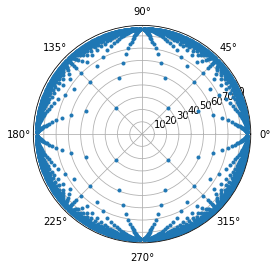

In [11]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phi_visible, np.degrees(np.pi-theta_from_tel), '.')

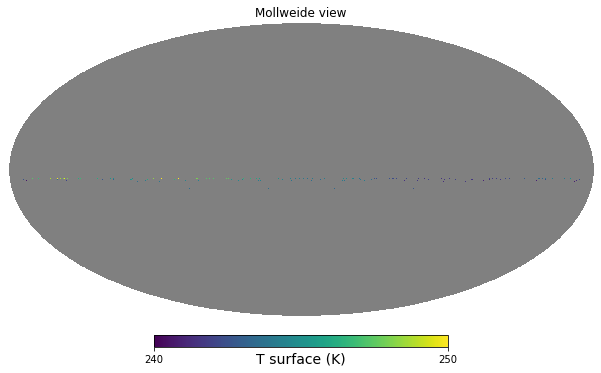

In [12]:
ground_map = np.zeros(hp.nside2npix(512))
ground_map[hp.ang2pix(512, theta_from_tel, phi_visible)] = temperature[hp.ang2pix(512, theta_visible, np.pi-phi_visible)]
ground_map[ground_map[:]==0]=hp.UNSEEN
#ground_map = hp.ud_grade(ground_map, 4)
hp.mollview(ground_map, xsize=1800, unit="T surface (K)", min=240, max=250)

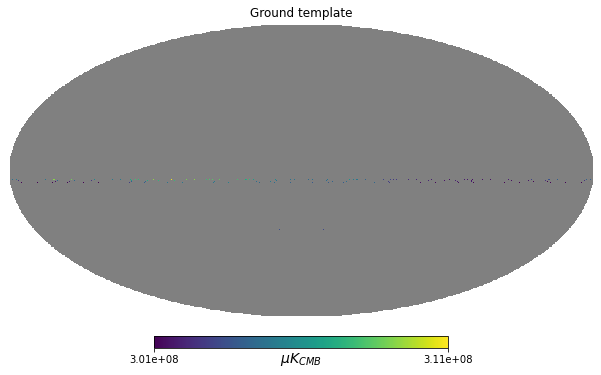

In [13]:
h = 6.62e-34
c = 3e8
k_b = 1.38e-23
freq=95e9
frac_bwidth = 0.2
T_cmb = 2.72548 

def tb2b(tb, nu):
    #Convert blackbody temperature to spectral
    x = h*nu/(k_b*tb)
    return 2*h*nu**3/c**2/(np.exp(x) - 1)

def dBdT(tb, nu):
    x = h*nu/(k_b*tb)
    slope = 2*k_b*nu**2/c**2*((x/2)/np.sinh(x/2))**2
    return slope

freq_band=np.linspace(freq*(1-frac_bwidth/2.), freq*(1+frac_bwidth/2.), 201)
tcmb_ground = np.ones(12*512**2)*hp.UNSEEN
for i, tb in enumerate(ground_map):
    if tb!=hp.UNSEEN:
        bolo = np.trapz(tb2b(tb, freq_band), freq_band)
        corr = np.trapz(dBdT(T_cmb, freq_band), freq_band)
        tcmb_ground[i] = bolo/corr*1e6
        
hp.mollview(tcmb_ground, unit=r"$\mu K_{CMB}$", title=r"Ground template", min=301e6, max=311e6)

We are missing a lot of pixels near the pole, but there are some measures, as seen if we downgrade the resolution:

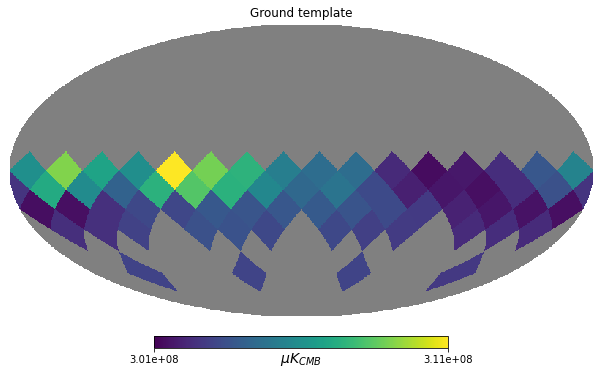

In [14]:
hp.mollview(hp.ud_grade(tcmb_ground, 4), unit=r"$\mu K_{CMB}$", title=r"Ground template", min=301e6, max=311e6)

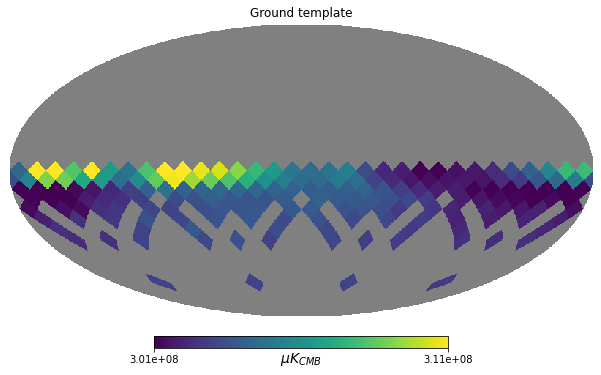

In [15]:
hp.mollview(hp.ud_grade(tcmb_ground, 8), unit=r"$\mu K_{CMB}$", title=r"Ground template", min=301e6, max=311e6)

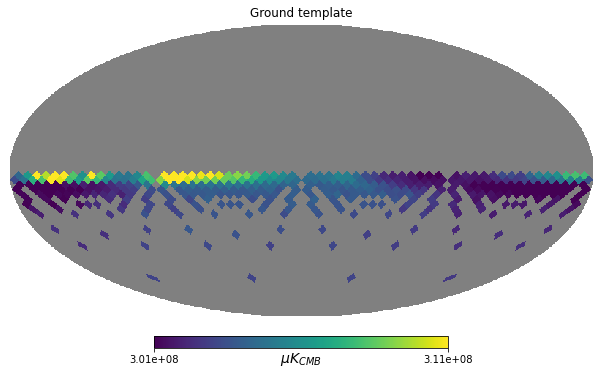

In [16]:
hp.mollview(hp.ud_grade(tcmb_ground, 16), unit=r"$\mu K_{CMB}$", title=r"Ground template", min=301e6, max=311e6)

Ideally, we want a NSIDE=128 map where we fill out the missing parts. 

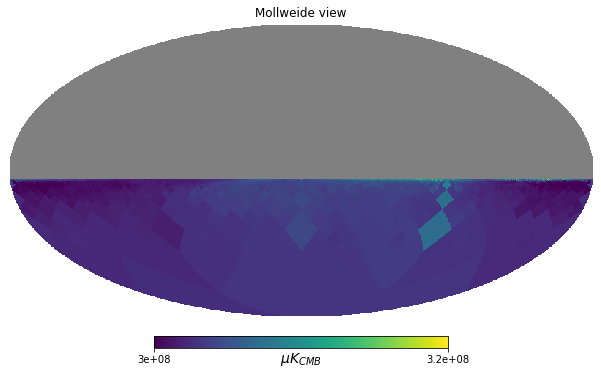

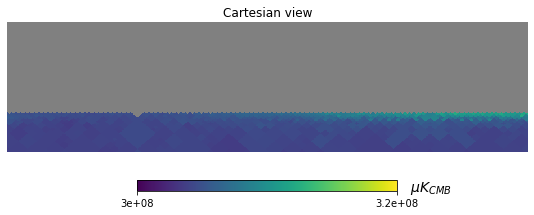

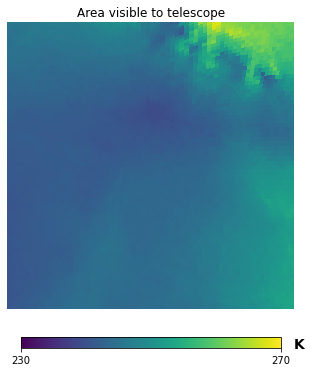

In [17]:
map_low = hp.ud_grade(tcmb_ground, 2)
for i in [4, 8, 16, 32, 64, 128]:
    
    map_normal = hp.ud_grade(tcmb_ground, i)
    map_horizon = np.amin(np.argwhere(map_normal!=hp.UNSEEN))
    map_normal[map_horizon:] = np.where(map_normal[map_horizon:]!=hp.UNSEEN,
                            map_normal[map_horizon:], hp.ud_grade(map_low, i)[map_horizon:])
    map_low = map_normal
hp.mollview(map_normal, min=3e8, max=3.2e8, unit=r'$\mu K_{CMB}$', flip="geo") 
hp.cartview(map_normal, min=3e8, max=3.2e8, unit=r'$\mu K_{CMB}$', lonra=[-20,60], latra=[-10,10], flip="geo")
hp.cartview(temperature, xsize=1200, min=230, max=270, flip="geo", rot=[0,-90,0], 
            latra=[-np.degrees(theta_fov), np.degrees(theta_fov)], 
            lonra=[-np.degrees(theta_fov), np.degrees(theta_fov)],
           unit="K", title="Area visible to telescope")

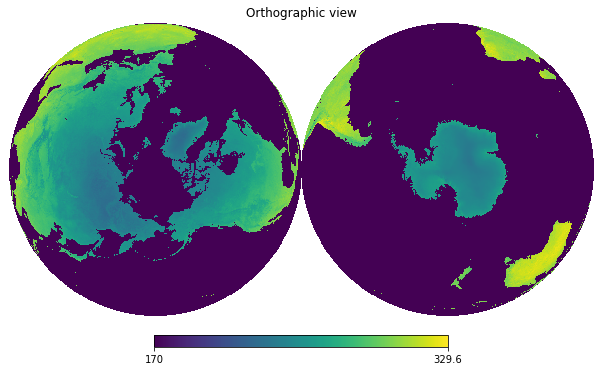

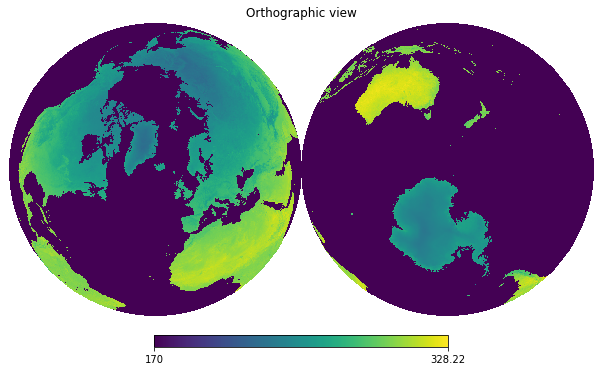

In [18]:
#What if we aren't at the south pole?
def rotate_to_telescope(inmap, tel_lat, tel_lon):
    nside = hp.npix2nside(inmap.shape[0])
    rlon = np.radians(tel_lon)-np.pi
    rlat = np.pi/2.-np.radians(tel_lat)
    x0, y0, z0 = hp.pix2vec(512, np.arange(hp.nside2npix(512)))
    x1 =  x0*np.cos(rlat)+z0*np.sin(rlat)
    z = -x0*np.sin(rlat)+z0*np.cos(rlat)
    x = x1*np.cos(rlon)-y0*np.sin(rlon)
    y = x1*np.sin(rlon)+y0*np.cos(rlon)
    pix_prime = hp.vec2pix(512, x,y,z)
    return inmap[pix_prime]

lat = 64.15#[-90,+90]
lon = -23#[-180, 180]
world_map_from_telescope = rotate_to_telescope(temperature, lat, lon)
hp.orthview(temperature, xsize=1200, min=170, flip="geo", rot=[0,90,0])
hp.orthview(world_map_from_telescope, xsize=1200, min=170, flip="geo",  rot=[0,90,0])

In [19]:
def telescope_view_angles(nside_in, telescope_altitude, surface_height=0, r_earth =6.371e6):
    """
    calculates the coordinates of a map with a given nside projected on the telescope's view,
    given the telescope's altitude, the height of the ground, and the radius of the earth 
    at the telescope's location. Doesn't account for variations in ground height throughout 
    the fov.
    Returns the coordinates visible in the input map, and their projection in the telescope's map.
    """
    r_ground = r_earth+surface_height
    tele_h_abg = telescope_altitude - surface_height
    theta_fov = np.arccos((r_ground)/(r_ground+tele_h_abg))
    
    theta, phi = hp.pix2ang(512, np.arange(hp.nside2npix(512)))
    theta_visible = theta[theta<theta_fov]
    phi_visible = phi[theta<theta_fov]
    theta_from_tel = np.arctan2(r_anta*np.sin(theta_visible), r_anta*(1-np.cos(theta_visible))+tele_h_abg)
    theta_from_tel = np.pi-theta_from_tel #Up is down
    phi_from_tel = np.pi-phi_visible #Therefore left is right
    return(theta_visible, phi_visible, theta_from_tel, phi_from_tel)
tele_h = 3e4
theta_visible, phi_visible, theta_from_tel, phi_from_tel = telescope_view_angles(512, tele_h)
theta_fov = np.amax(theta_visible)

45.0 180.0 -180.0 180.0


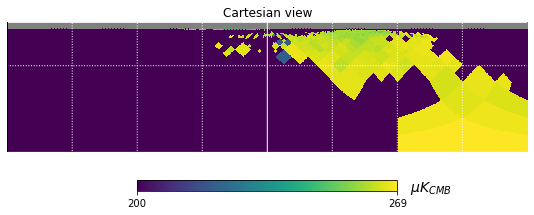

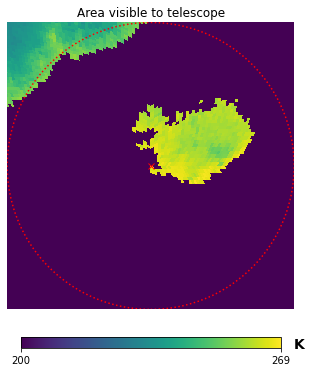

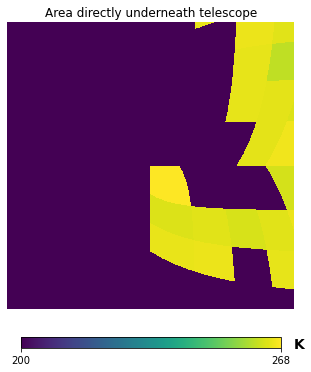

In [20]:
def create_ground_map(world_map, theta_visible, phi_visible, theta_from_tel, phi_from_tel, 
                      nside_out=128, cmb=True, freq=95., frac_bwidth=.2):
    """
    Creates a ground template given a world map and sets of coordinates (see telescope_view_angles)
    Returns a filled-out ground template
    options: 
    nside_out (int): healpix NSIDE of the output map
    cmb(bool): Whether to convert the output map to CMB brightness temperature units (muK) 
    freq(float): Center of the frequency band
    frac_bwidth(float): Band width, as a fraction of the central frequency
    """
    nside_world = hp.npix2nside(world_map.shape[0])
    ground_map = np.ones(hp.nside2npix(nside_out))*hp.UNSEEN
    ground_pix = hp.ang2pix(nside_out, theta_from_tel, phi_from_tel)
    ground_map[ground_pix] = world_map_from_telescope[hp.ang2pix(nside_world, theta_visible, phi_visible)]
    if cmb:
        freq_band=np.linspace(freq*(1-frac_bwidth/2.), freq*(1+frac_bwidth/2.), 201)
        for i, tb in enumerate(ground_map):
            if tb!=hp.UNSEEN:
                bolo = np.trapz(tb2b(tb, freq_band), freq_band)
                corr = np.trapz(dBdT(T_cmb, freq_band), freq_band)
                ground_map[i] = bolo/corr*1e6
    pix_pow = int(np.log2(nside_out))
    map_low = hp.ud_grade(ground_map, 2)
    for i in range(pix_pow+1):

        nside = int(2**i)
        map_normal = hp.ud_grade(ground_map, nside)
        map_horizon = np.amin(hp.ang2pix(nside, theta_from_tel, phi_visible))
        map_normal[map_horizon:] = np.where(map_normal[map_horizon:]!=hp.UNSEEN,
                                map_normal[map_horizon:], hp.ud_grade(map_low, nside)[map_horizon:])
        map_low = map_normal       
    
    return(map_normal)

map_normal = create_ground_map(world_map_from_telescope, 
                               theta_visible, phi_visible, theta_from_tel, phi_from_tel,
                              cmb=False)

hp.cartview(map_normal, min=200, unit=r'$\mu K_{CMB}$', flip="geo", xsize=1200, latra=[-90,0])
hp.graticule(dmer=45, dpar=60, c="w")
hp.cartview(world_map_from_telescope, xsize=1200, min=200, flip="geo", 
            latra=[-np.degrees(theta_fov), np.degrees(theta_fov)], 
            lonra=[-np.degrees(theta_fov), np.degrees(theta_fov)], rot=[0,90,0],
           unit="K", title="Area visible to telescope")
vis_phi = np.linspace(0,2*np.pi, num=1001)
vis_theta = np.ones(1001)*theta_fov
hp.projplot(0, 0, 'rx')
hp.projplot(vis_theta, vis_phi, 'r:')
theta_close = np.amax(theta_visible[theta_from_tel>0.66*np.pi])
hp.cartview(world_map_from_telescope, xsize=1200, min=200, flip="geo", 
            latra=[-np.degrees(theta_close), np.degrees(theta_close)], 
            lonra=[-np.degrees(theta_close), np.degrees(theta_close)], rot=[0,90,0],
           unit="K", title="Area directly underneath telescope")